In [37]:
%matplotlib inline
import numpy as np
import matplotlib.pylab as plt
import pandas as pd
import scipy.io
from scipy.stats import pearsonr
from pymc import Normal,Uniform,InverseGamma,MvNormalCov,MCMC
from pymc.Matplot import plot
import pymc as pm

In [38]:
oxy_data=scipy.io.loadmat('oxy_ts.mat')

The Standard Deviations for Placebo Amygdala (1.9448291803147304) and Placebo L Frontal Sup (1.881435499287153).
The Standard Deviations for Oxytocin Amygdala (4.157893364240837) and Oxytocin L Frontal Sup (1.6481695586975138).


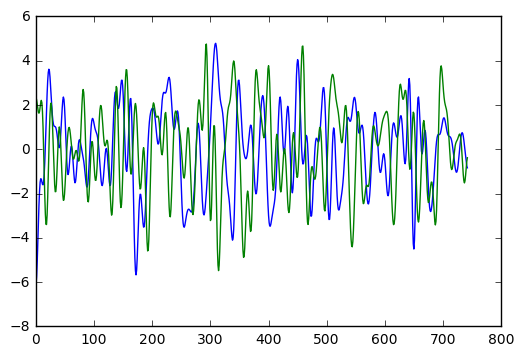

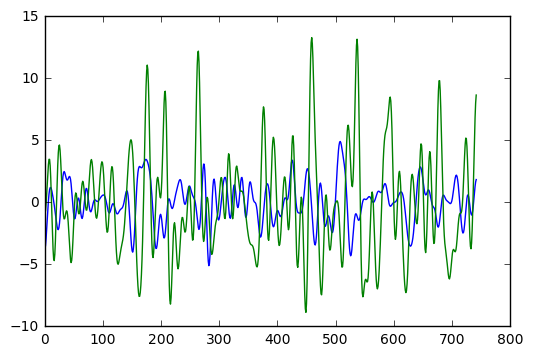

In [39]:
#import fMRI data for Oxytocin and Placebo and the varying brain regions.
sup_oxy=oxy_data['ts_roi_oxytocin'][:,0]
orb_oxy=oxy_data['ts_roi_oxytocin'][:,1]
pos_oxy=oxy_data['ts_roi_oxytocin'][:,2]
amy_oxy=oxy_data['ts_roi_oxytocin'][:,3]
sup_pla=oxy_data['ts_roi_placebo'][:,0]
orb_pla=oxy_data['ts_roi_placebo'][:,1]
pos_pla=oxy_data['ts_roi_placebo'][:,2]
amy_pla=oxy_data['ts_roi_placebo'][:,3]
print("The Standard Deviations for Placebo Amygdala ({}) and Placebo L Frontal Sup ({}).".format(amy_pla.std(),sup_pla.std()))
plt.figure()
plt.plot(sup_pla)
plt.plot(amy_pla)
print("The Standard Deviations for Oxytocin Amygdala ({}) and Oxytocin L Frontal Sup ({}).".format(amy_oxy.std(),sup_oxy.std()))
plt.figure()
plt.plot(sup_oxy)
plt.plot(amy_oxy)

# Example of What Correlated Data Might Look Like
The data below is an example of data that looks more correlated vs less correlated. It should be an ellipse in a diagonal pattern. 

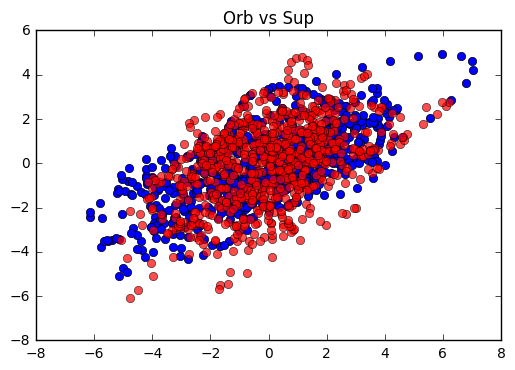

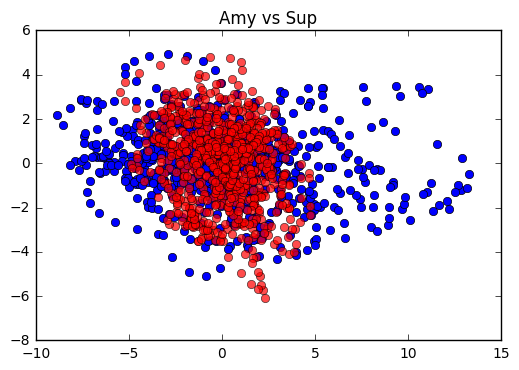

In [40]:
plt.figure(1)
plt.plot(orb_oxy, sup_oxy, 'o')
plt.plot(orb_pla, sup_pla, 'ro',  alpha=0.7)
plt.title("Orb vs Sup")
plt.figure(2)
plt.plot(amy_oxy, sup_oxy, 'o')
plt.plot(amy_pla, sup_pla, 'ro', alpha=0.7)
plt.title("Amy vs Sup")

# Pearson Correlation Using a Bayesian Technique

For the Correlation, we used a technique that was similar to the one used in the provided Oxytocin Notebook. The idea is to calcluate the correlation using bayesian technique
$$\rho_{X,Y} = \frac{\sum_{i=1}^{N}(x_{i}-\bar{x})(y_{i}-\bar{y})}{\sqrt{\sum_{i=1}^{N}(x_{i}-\bar{x})^2}\sqrt{\sum_{i=1}^{N}(y_{i}-\bar{y})^2}}$$

Keep in mind that this equation written more simply is the cov(X,Y) divided by the standard deviation of each. 

The idea was to use try and figure out the distribution for 
$$\Delta_{} \rho = \rho_{oxytocin} - \rho_{placebo}$$

To do that, we decided to use a "bayesian" T-Test technique where we calucluted:
$$Y_{i,1} = \mu + \delta + N(0,\sigma^{2})$$
$$Y_{i,2} = \mu -\delta + N(0,\sigma^{2})$$



In [41]:
#stack the data
data_pla_so=np.vstack((orb_pla,sup_pla)).T
data_oxy_so=np.vstack((orb_oxy,sup_oxy)).T
data_pla_sp=np.vstack((pos_pla,sup_pla)).T
data_oxy_sp=np.vstack((pos_oxy,sup_oxy)).T
data_pla_sa=np.vstack((amy_pla,sup_pla)).T
data_oxy_sa=np.vstack((amy_oxy,sup_oxy)).T

## Sup vs Orb

In [42]:
#priors for the placebo
#sup vs orb
rho_pla_so=Uniform('rho_pla',-1.0,1.0)
sigma0_pla_so=10.0
nu0_pla_so=1.0
sig1_pla_so=Uniform('sig1_pla',0,10.0)
sig2_pla_so=Uniform('sig2_pla',0,10.0)
mu1_pla_so=Normal('mu1_pla',0.0,1/sig1_pla_so)
mu2_pla_so=Normal('mu2_pla',0.0,1/sig2_pla_so)

#priors for the oxytocin
rho_oxy_so=Uniform('rho_oxy',-1.0,1.0)
sigma0_oxy_so=10.0
nu0_oxy_so=1.0
sig1_oxy_so=Uniform('sig1_oxy',0,10.0)
sig2_oxy_so=Uniform('sig2_oxy',0,10.0)
mu1_oxy_so=Normal('mu1_oxy',0.0,1/sig1_oxy_so)
mu2_oxy_so=Normal('mu2_oxy',0.0,1/sig2_oxy_so)

nu0_drho_so=1.0
gamma0_drho_so=1
mu0_drho_so=0
sigma0_drho_so=0.2
delta0_drho_so=pm.Normal('delta', -1,1)
tau0_drho_so=1
#priors for ttest



In [43]:
#distributions for sup vs orb
distribution_pla_so=MvNormalCov('distribution_pla_so',
                      mu=[mu1_pla_so,mu2_pla_so],
                      C=[[sig1_pla_so**2,rho_pla_so*sig1_pla_so*sig2_pla_so],[rho_pla_so*sig1_pla_so*sig2_pla_so,sig2_pla_so**2]],
                      value=data_pla_so,
                      observed=True)

distribution_oxy_so=MvNormalCov('distribution_oxy_so',
                      mu=[mu1_oxy_so,mu2_oxy_so],
                      C=[[sig1_oxy_so**2,rho_oxy_so*sig1_oxy_so*sig2_oxy_so],[rho_oxy_so*sig1_oxy_so*sig2_oxy_so,sig2_oxy_so**2]],
                      value=data_oxy_so,
                      observed=True)

#drho likelyhood function
sigmaSquare_drho_so=pm.InverseGamma('sigmaSquare_so',nu0_drho_so/2.0,nu0_drho_so*sigma0_drho_so**2/2.0)
mu_drho_so=pm.Normal('mu_drho_so',mu=mu0_drho_so,tau=1/gamma0_drho_so**2)
delta_drho_so=pm.Normal('delta_so',mu=delta0_drho_so,tau=1/tau0_drho_so**2)
#distributions
s1_so=pm.Normal('s1',mu=mu_drho_so+delta_drho_so,tau=1/sigmaSquare_drho_so,value=rho_oxy_so,observed=True)
s2_so=pm.Normal('s2',mu=mu_drho_so-delta_drho_so,tau=1/sigmaSquare_drho_so,value=rho_pla_so,observed=True)

In [44]:
m_so=MCMC([[rho_pla_so,sig1_pla_so,sig2_pla_so,mu1_pla_so,mu2_pla_so,distribution_pla_so],
            [rho_oxy_so,sig1_oxy_so,sig2_oxy_so,mu1_oxy_so,mu2_oxy_so,distribution_oxy_so],
            [sigmaSquare_drho_so,mu_drho_so,delta_drho_so,s1_so,s2_so]])


## Sup vs Pos

In [45]:
#sup vs pos
#priors for the placebo
rho_pla_sp=Uniform('rho_pla',-1.0,1.0)
sigma0_pla_sp=10.0
nu0_pla_sp=1.0
sig1_pla_sp=Uniform('sig1_pla',0,10.0)
sig2_pla_sp=Uniform('sig2_pla',0,10.0)
mu1_pla_sp=Normal('mu1_pla',0.0,1/sig1_pla_sp)
mu2_pla_sp=Normal('mu2_pla',0.0,1/sig2_pla_sp)
#priors for the oxytocin
rho_oxy_sp=Uniform('rho_oxy',-1.0,1.0)
sigma0_oxy_sp=10.0
nu0_oxy_sp=1.0
sig1_oxy_sp=Uniform('sig1_oxy',0,10.0)
sig2_oxy_sp=Uniform('sig2_oxy',0,10.0)
mu1_oxy_sp=Normal('mu1_oxy',0.0,1/sig1_oxy_sp)
mu2_oxy_sp=Normal('mu2_oxy',0.0,1/sig2_oxy_sp)
#priors for ttest
nu0_drho_sp=1.0
gamma0_drho_sp=1
mu0_drho_sp=0
sigma0_drho_sp=0.2
delta0_drho_sp=pm.Normal('delta', -1,1)
tau0_drho_sp=1

In [46]:
#distributions for sup vs pos
distribution_pla_sp=MvNormalCov('distribution_pla_sp',
                      mu=[mu1_pla_sp,mu2_pla_sp],
                      C=[[sig1_pla_sp**2,rho_pla_sp*sig1_pla_sp*sig2_pla_sp],[rho_pla_sp*sig1_pla_sp*sig2_pla_sp,sig2_pla_sp**2]],
                      value=data_pla_sp,
                      observed=True)

distribution_oxy_sp=MvNormalCov('distribution_oxy_sp',
                      mu=[mu1_oxy_sp,mu2_oxy_sp],
                      C=[[sig1_oxy_sp**2,rho_oxy_sp*sig1_oxy_sp*sig2_oxy_sp],[rho_oxy_sp*sig1_oxy_sp*sig2_oxy_sp,sig2_oxy_sp**2]],
                      value=data_oxy_sp,
                      observed=True)

#drho likelyhood function
sigmaSquare_drho_sp=pm.InverseGamma('sigmaSquare_sp',nu0_drho_sp/2.0,nu0_drho_sp*sigma0_drho_sp**2/2.0)
mu_drho_sp=pm.Normal('mu_drho_sp',mu=mu0_drho_sp,tau=1/gamma0_drho_sp**2)
delta_drho_sp=pm.Normal('delta_sp',mu=delta0_drho_sp,tau=1/tau0_drho_sp**2)
#distributions
s1_sp=pm.Normal('s1',mu=mu_drho_sp+delta_drho_sp,tau=1/sigmaSquare_drho_sp,value=rho_oxy_sp,observed=True)
s2_sp=pm.Normal('s2',mu=mu_drho_sp-delta_drho_sp,tau=1/sigmaSquare_drho_sp,value=rho_pla_sp,observed=True)

In [47]:
m_sp=MCMC([[rho_pla_sp,sig1_pla_sp,sig2_pla_sp,mu1_pla_sp,mu2_pla_sp,distribution_pla_sp],
            [rho_oxy_sp,sig1_oxy_sp,sig2_oxy_sp,mu1_oxy_sp,mu2_oxy_sp,distribution_oxy_sp],
            [sigmaSquare_drho_sp,mu_drho_sp,delta_drho_sp,s1_sp,s2_sp]])

## Sup vs Amy

In [48]:
#sup vs amy
#priors for the placebo
rho_pla_sa=Uniform('rho_pla',-1.0,1.0)
sigma0_pla_sa=10.0
nu0_pla_sa=1.0
sig1_pla_sa=Uniform('sig1_pla',0,10.0)
sig2_pla_sa=Uniform('sig2_pla',0,10.0)
mu1_pla_sa=Normal('mu1_pla',0.0,1/sig1_pla_sa)
mu2_pla_sa=Normal('mu2_pla',0.0,1/sig2_pla_sa)
#priors for the oxytocin
rho_oxy_sa=Uniform('rho_oxy',-1.0,1.0)
sigma0_oxy_sa=10.0
nu0_oxy_sa=1.0
sig1_oxy_sa=Uniform('sig1_oxy',0,10.0)
sig2_oxy_sa=Uniform('sig2_oxy',0,10.0)
mu1_oxy_sa=Normal('mu1_oxy',0.0,1/sig1_oxy_sa)
mu2_oxy_sa=Normal('mu2_oxy',0.0,1/sig2_oxy_sa)
#priors for ttest
nu0_drho_sa=1.0
gamma0_drho_sa=1
mu0_drho_sa=0
sigma0_drho_sa=0.2
delta0_drho_sa=pm.Normal('delta', -1,1)
tau0_drho_sa=1

In [49]:
#distributions for sup vs amy
distribution_pla_sa=MvNormalCov('distribution_pla_sa',
                      mu=[mu1_pla_sa,mu2_pla_sa],
                      C=[[sig1_pla_sa**2,rho_pla_sa*sig1_pla_sa*sig2_pla_sa],[rho_pla_sa*sig1_pla_sa*sig2_pla_sa,sig2_pla_sa**2]],
                      value=data_pla_sa,
                      observed=True)

distribution_oxy_sa=MvNormalCov('distribution_oxy_sa',
                      mu=[mu1_oxy_sa,mu2_oxy_sa],
                      C=[[sig1_oxy_sa**2,rho_oxy_sa*sig1_oxy_sa*sig2_oxy_sa],[rho_oxy_sa*sig1_oxy_sa*sig2_oxy_sa,sig2_oxy_sa**2]],
                      value=data_oxy_sa,
                      observed=True)

#drho likelyhood function
sigmaSquare_drho_sa=pm.InverseGamma('sigmaSquare_sa',nu0_drho_sa/2.0,nu0_drho_sa*sigma0_drho_sa**2/2.0)
mu_drho_sa=pm.Normal('mu_drho_sa',mu=mu0_drho_sa,tau=1/gamma0_drho_sa**2)
delta_drho_sa=pm.Normal('delta_sa',mu=delta0_drho_sa,tau=1/tau0_drho_sa**2)
#distributions
s1_sa=pm.Normal('s1',mu=mu_drho_sa+delta_drho_sa,tau=1/sigmaSquare_drho_sa,value=rho_oxy_sa,observed=True)
s2_sa=pm.Normal('s2',mu=mu_drho_sa-delta_drho_sa,tau=1/sigmaSquare_drho_sa,value=rho_pla_sa,observed=True)

In [50]:
m_sa=MCMC([[rho_pla_sa,sig1_pla_sa,sig2_pla_sa,mu1_pla_sa,mu2_pla_sa,distribution_pla_sa],
            [rho_oxy_sa,sig1_oxy_sa,sig2_oxy_sa,mu1_oxy_sa,mu2_oxy_sa,distribution_oxy_sa],
            [sigmaSquare_drho_sa,mu_drho_sa,delta_drho_sa,s1_sp,s2_sp]])

In [51]:
m_so.sample(iter=10000,burn=1000,thin=10)

 [-----------------100%-----------------] 10000 of 10000 complete in 394.4 sec

In [52]:
m_sp.sample(iter=10000,burn=1000,thin=10)

 [-----------------100%-----------------] 10000 of 10000 complete in 405.1 sec

In [53]:
m_sa.sample(iter=10000,burn=1000,thin=10)

 [-----------------100%-----------------] 10001 of 10000 complete in 387.4 sec

In [54]:
m_so.summary()


mu2_oxy:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	-0.002           0.061            0.003            [-0.125  0.109]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	-0.115           -0.041          -0.002         0.039         0.121
	

mu_drho_so:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	-0.009           0.292            0.009            [-0.632  0.558]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	-0.626           -0.122          -0.009         0.094         0.566
	

sig2_oxy:
 
	Mean             SD               MC Error        95% HPD interval
	-----------

C:\Users\osman\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:225: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)


In [55]:
m_sp.summary()


mu1_pla:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	0.002            0.098            0.004            [-0.2    0.192]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	-0.198           -0.066          -0.003         0.073         0.199
	

delta_sp:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	-1.151           0.941            0.076            [-3.244 -0.068]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	-3.552           -1.624          -0.738         -0.471        -0.236
	

rho_oxy:
 
	Mean             SD               MC Error        95% HPD interval
	-------------

C:\Users\osman\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:225: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)


In [56]:
m_sa.summary()


sig2_oxy:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	1.65             0.045            0.002            [ 1.576  1.752]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	1.56             1.623           1.647          1.676         1.746
	

rho_oxy:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	-0.187           0.036            0.002            [-0.259 -0.121]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	-0.258           -0.211          -0.188         -0.159        -0.115
	

sigmaSquare_sa:
 
	Mean             SD               MC Error        95% HPD interval
	------

C:\Users\osman\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:225: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)


Plotting mu2_oxy
Plotting mu_drho_so
Plotting sig2_oxy
Plotting sig1_oxy
Plotting sig2_pla
Plotting mu1_oxy
Plotting delta_so
Plotting mu1_pla
Plotting rho_pla
Plotting sigmaSquare_so
Plotting rho_oxy
Plotting sig1_pla
Plotting mu2_pla


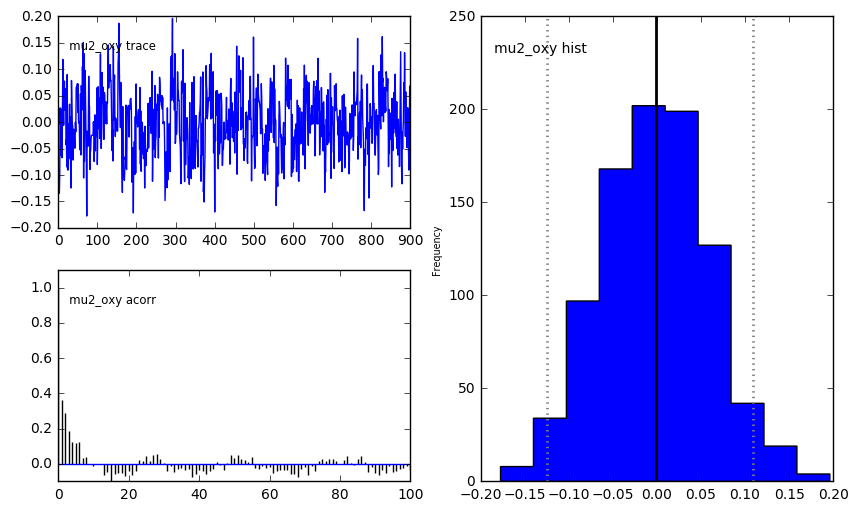

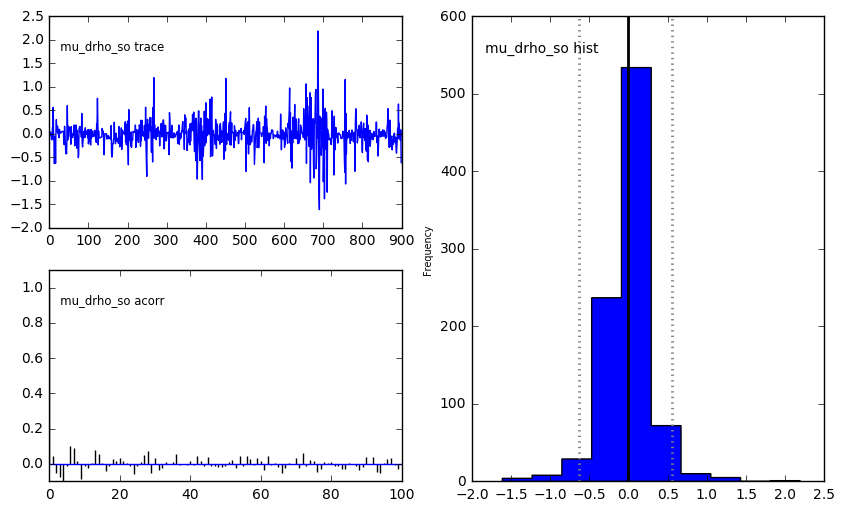

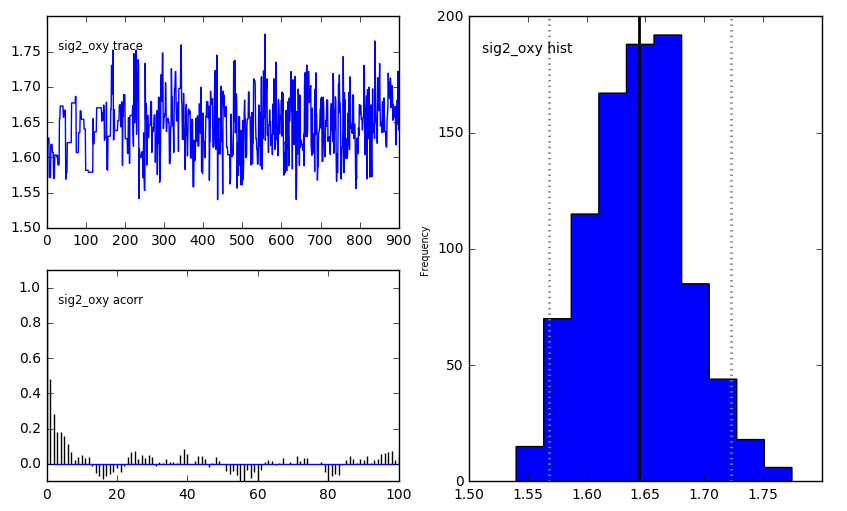

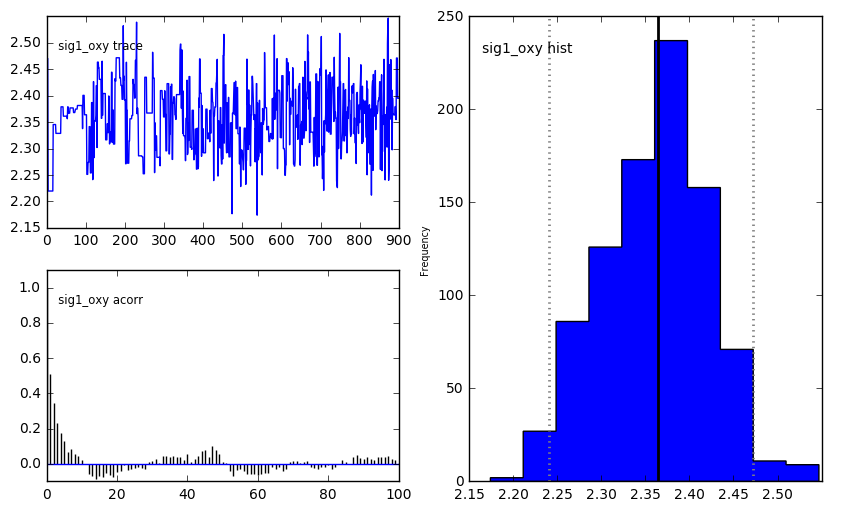

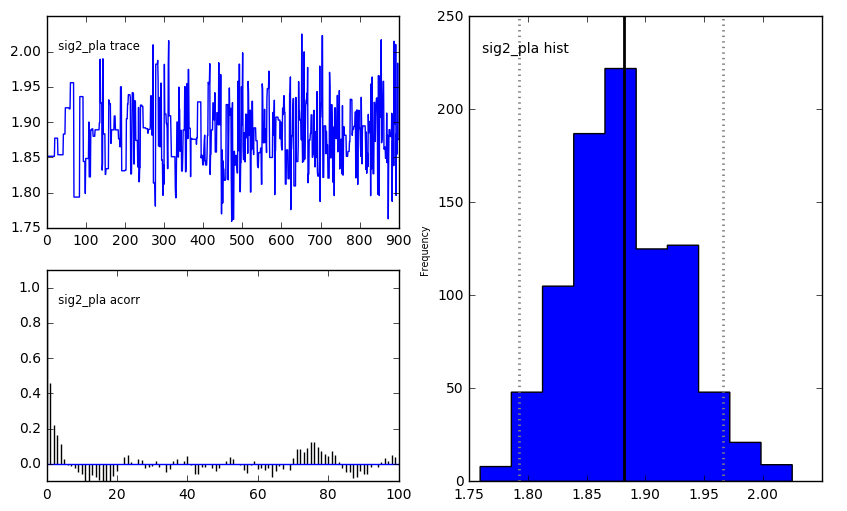

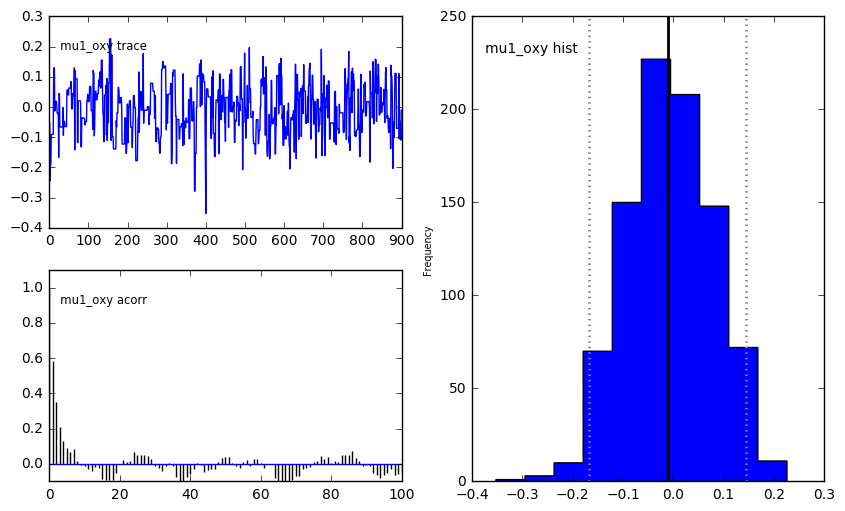

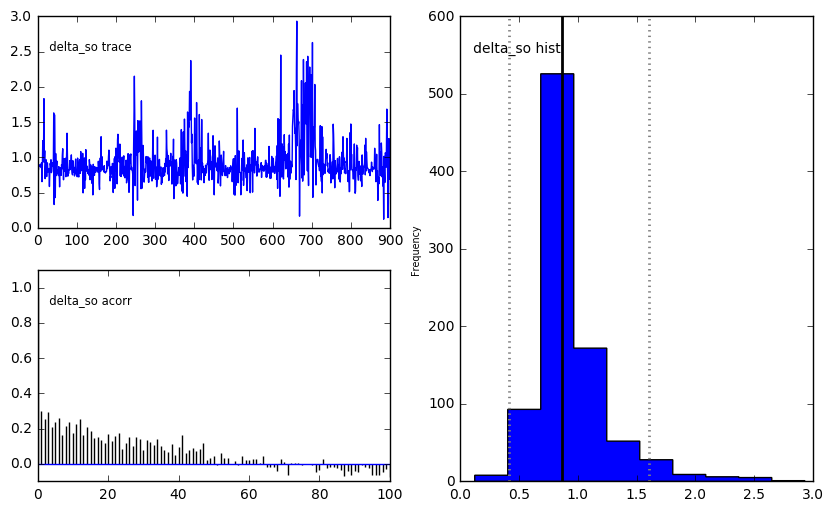

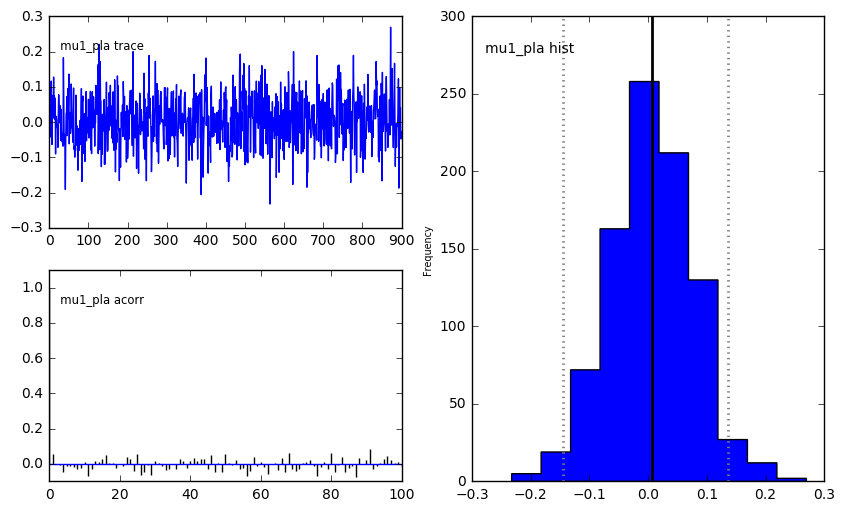

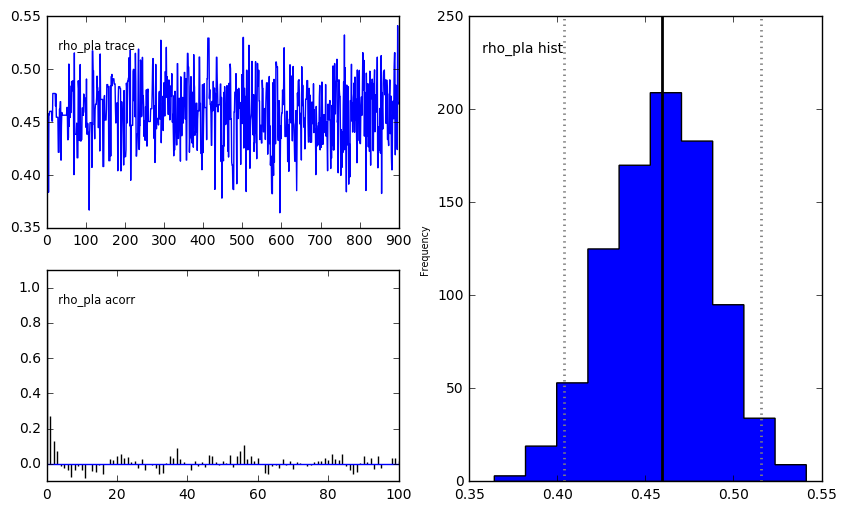

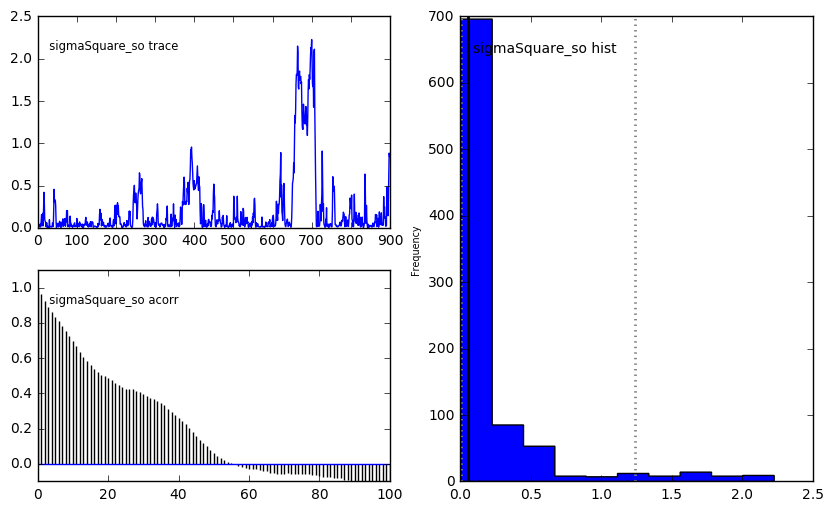

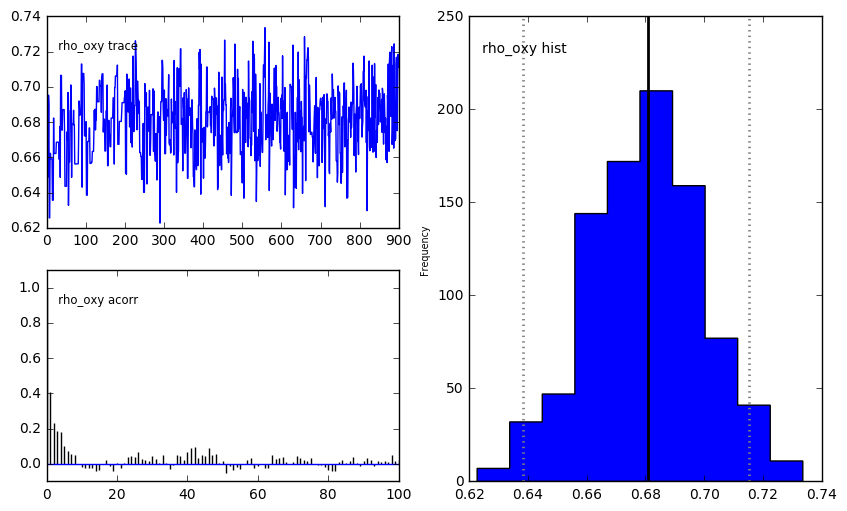

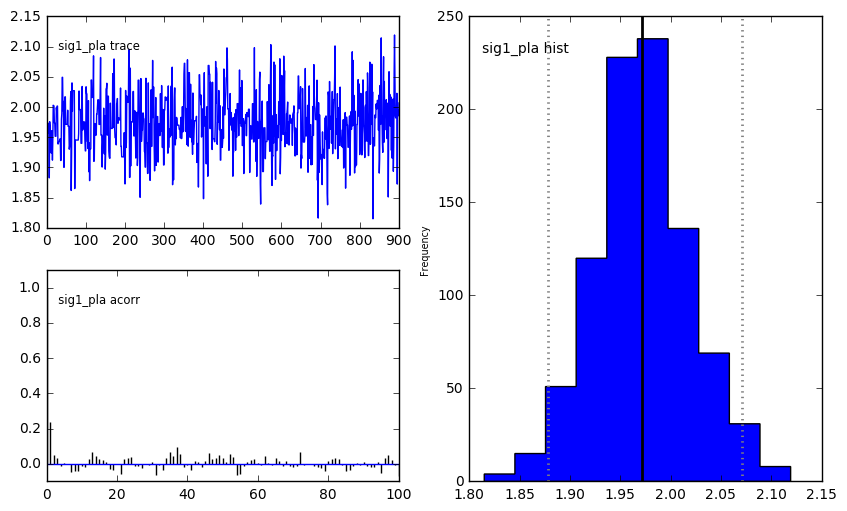

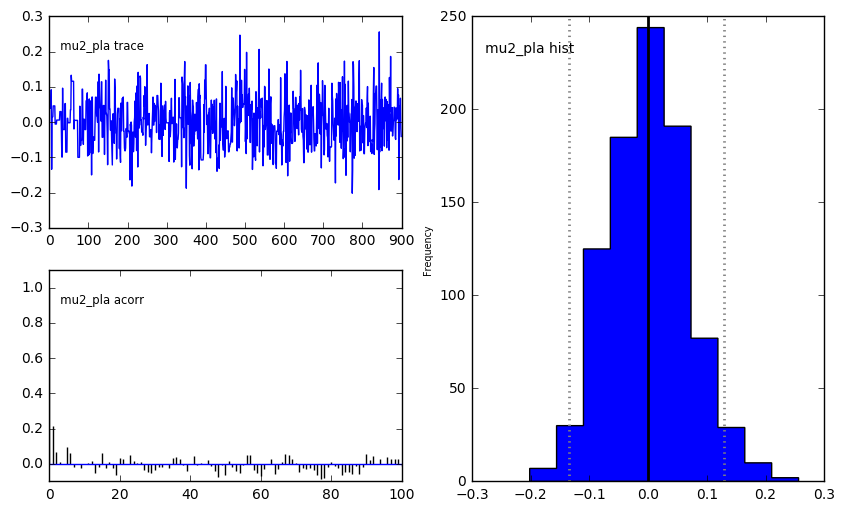

In [57]:
plot(m_so)

Plotting mu1_pla
Plotting delta_sp
Plotting rho_oxy
Plotting sig1_oxy
Plotting rho_pla
Plotting mu1_oxy
Plotting sig1_pla
Plotting mu2_pla
Plotting sig2_pla
Plotting mu2_oxy
Plotting sig2_oxy
Plotting mu_drho_sp
Plotting sigmaSquare_sp


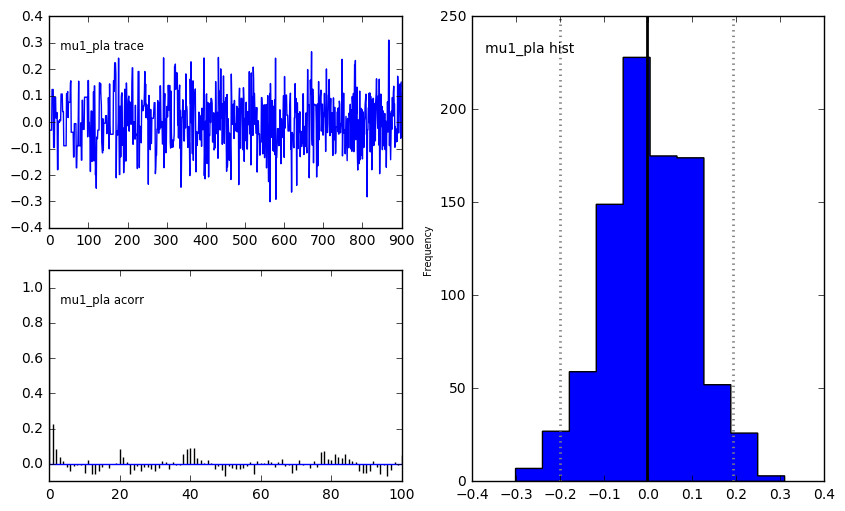

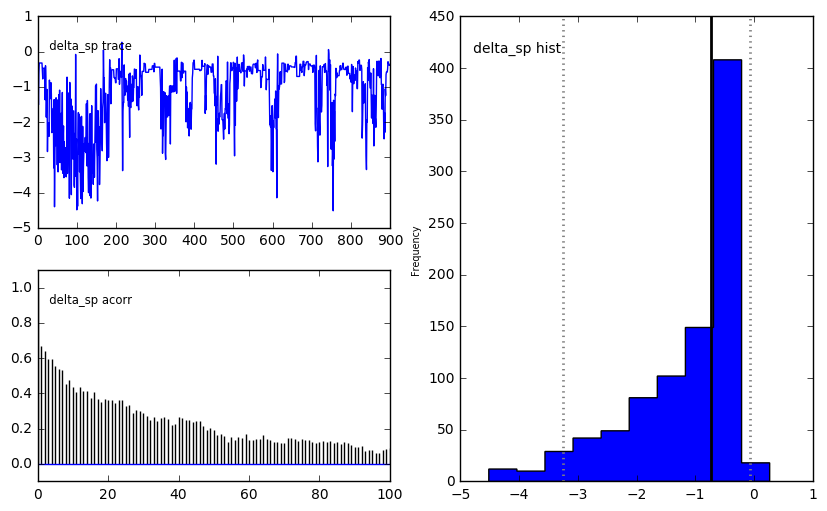

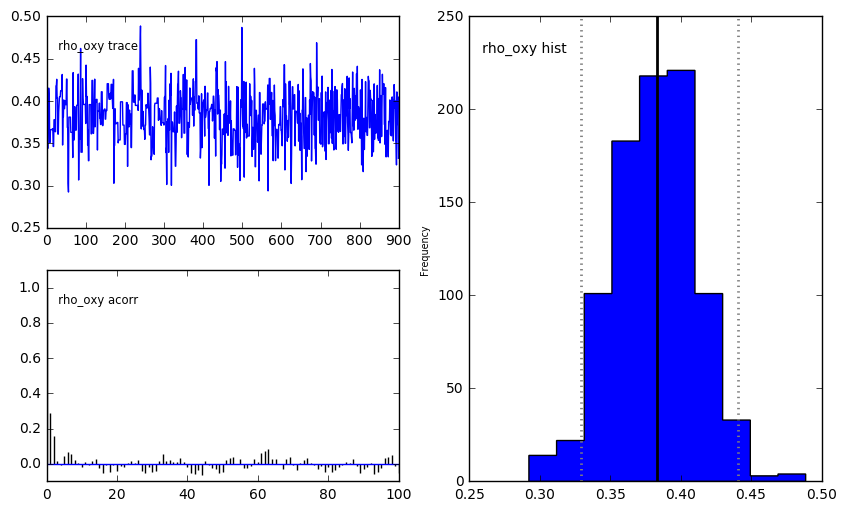

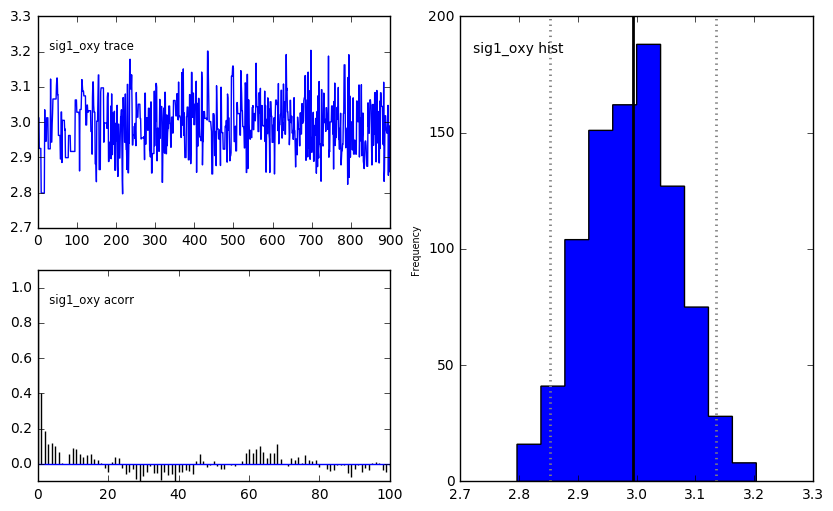

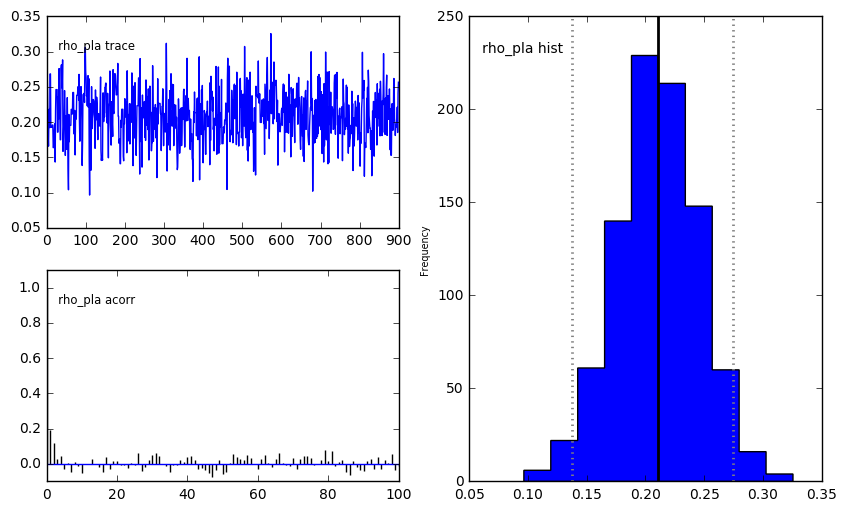

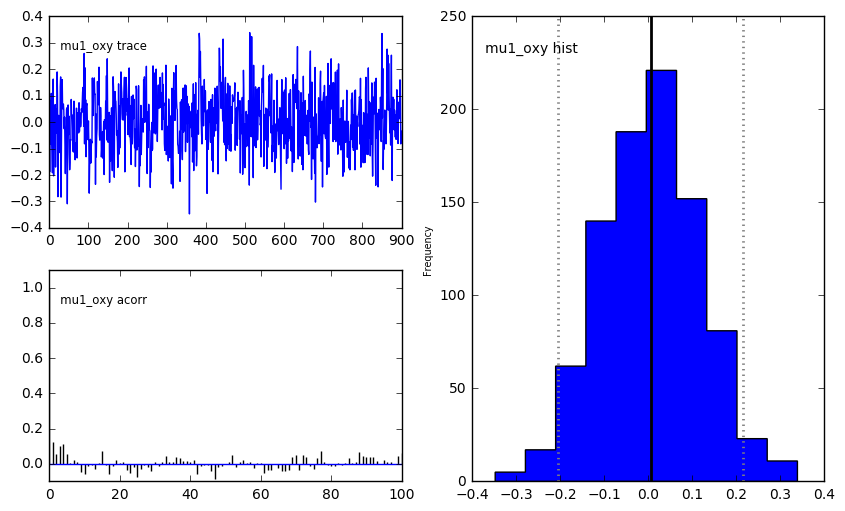

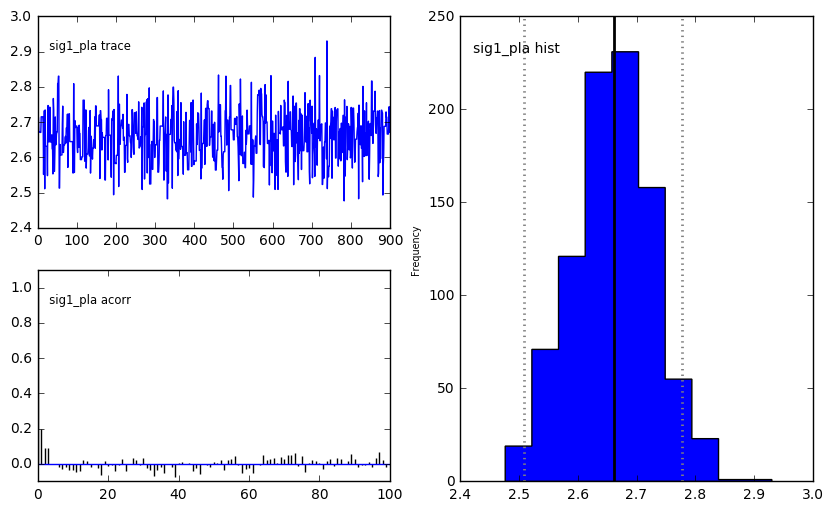

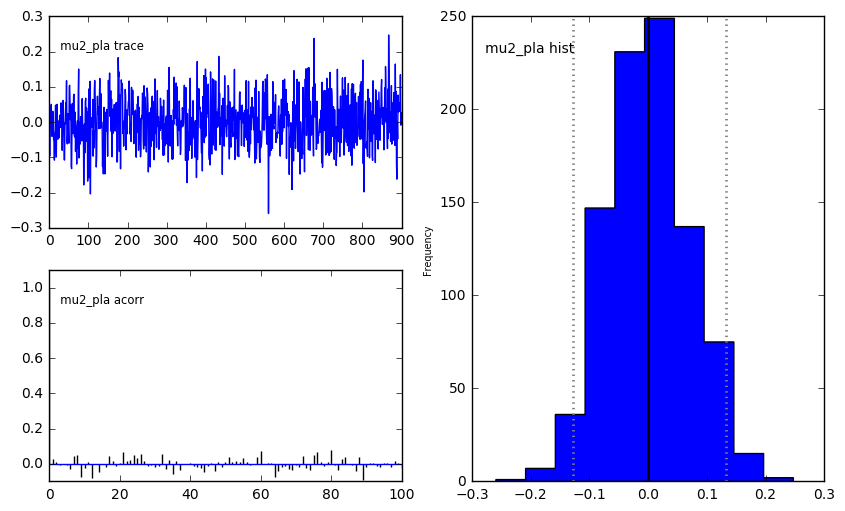

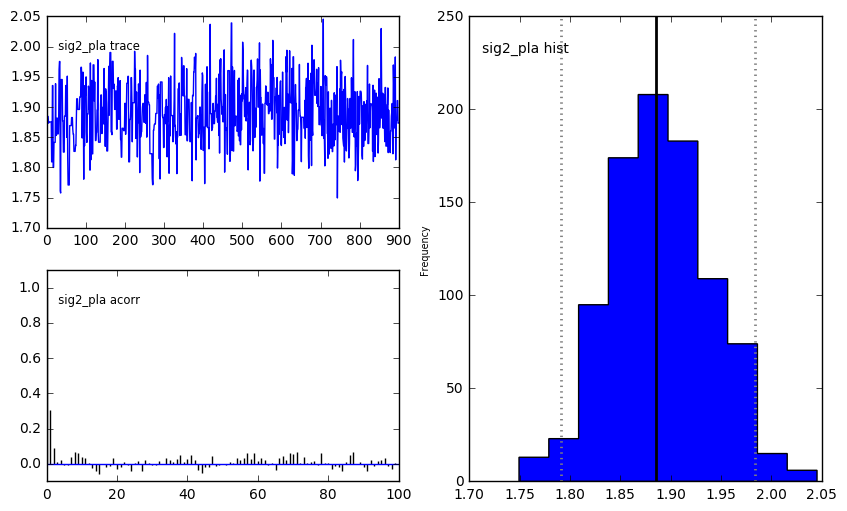

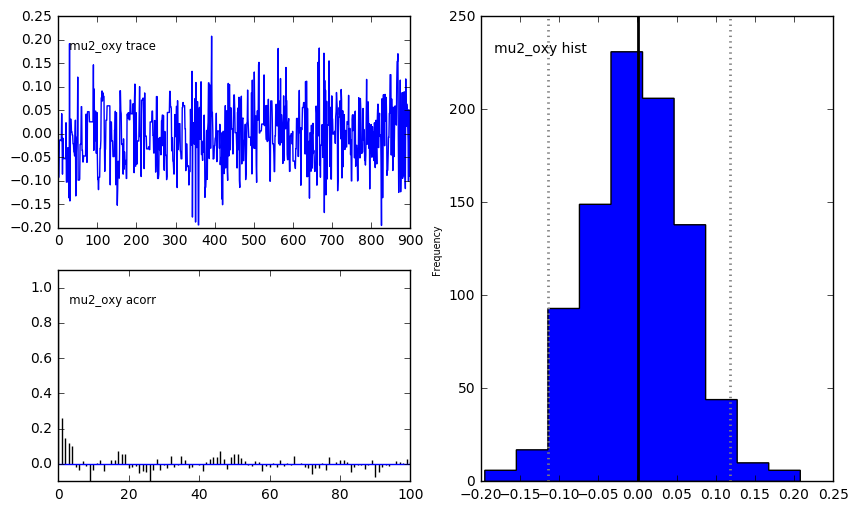

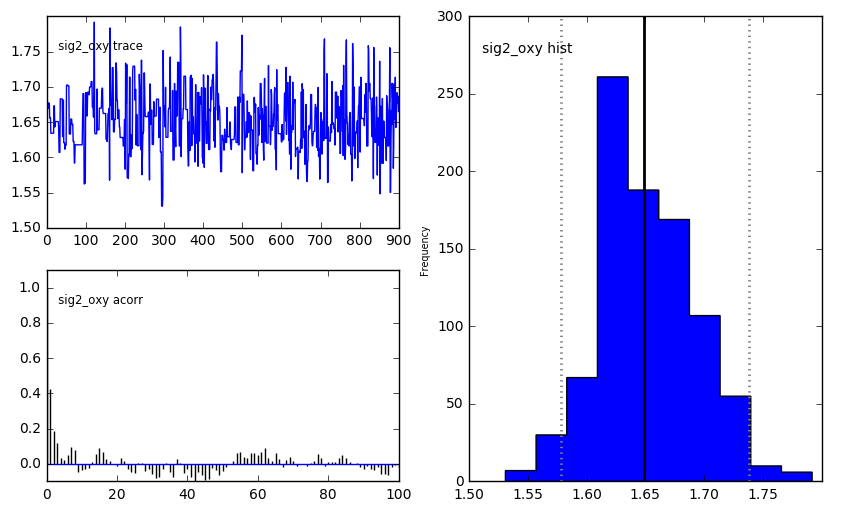

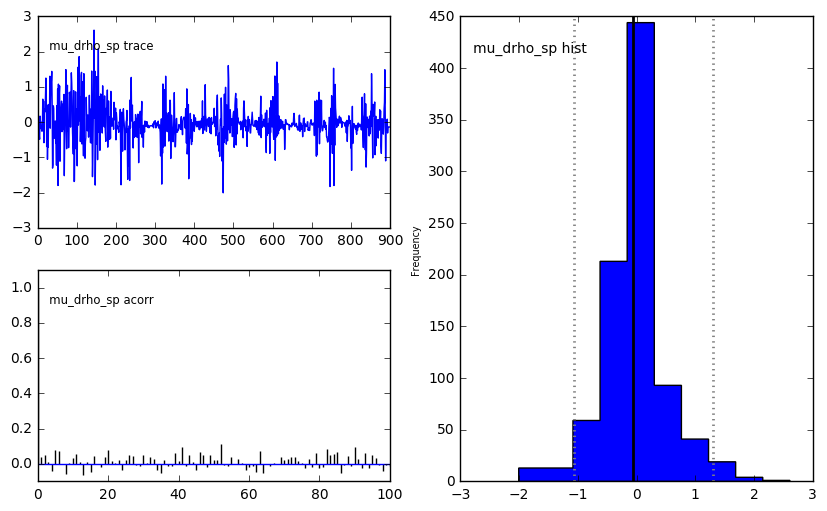

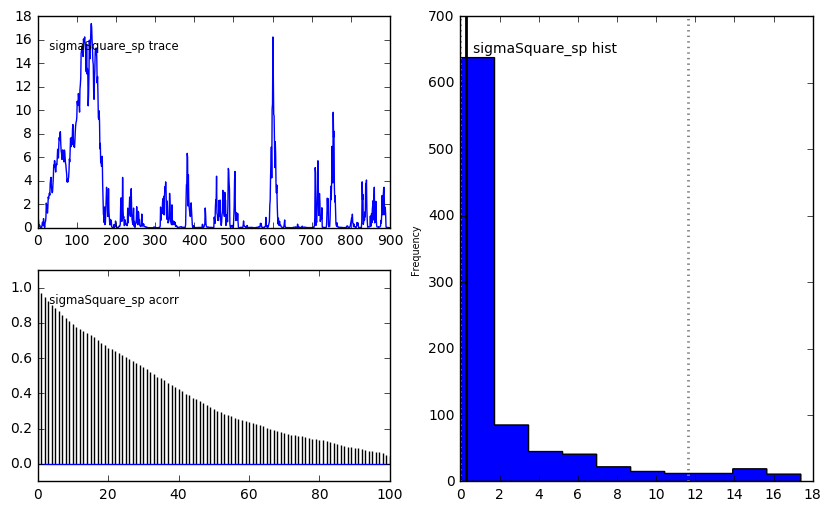

In [58]:
plot(m_sp)

Plotting sig2_oxy
Plotting rho_oxy
Plotting sigmaSquare_sa
Plotting sig2_pla
Plotting sig1_oxy
Plotting rho_pla
Plotting mu2_oxy
Plotting delta_sa
Plotting mu1_oxy
Plotting mu2_pla
Plotting mu1_pla
Plotting sig1_pla
Plotting mu_drho_sa


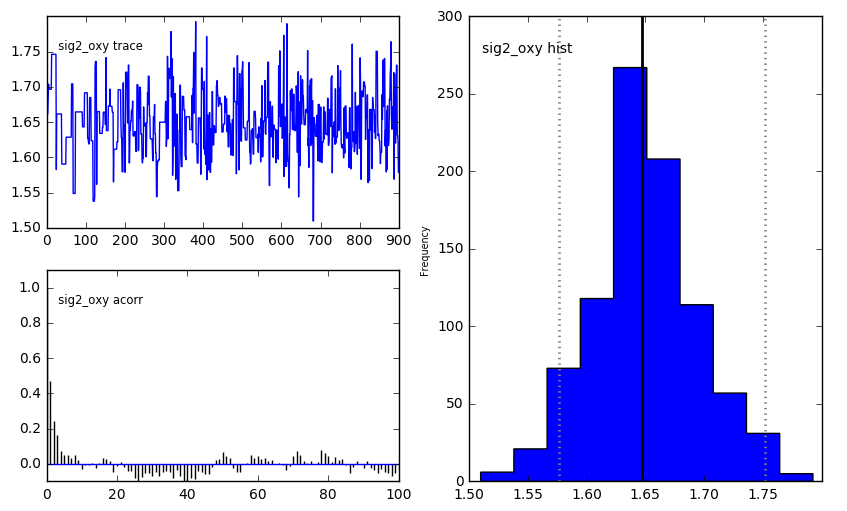

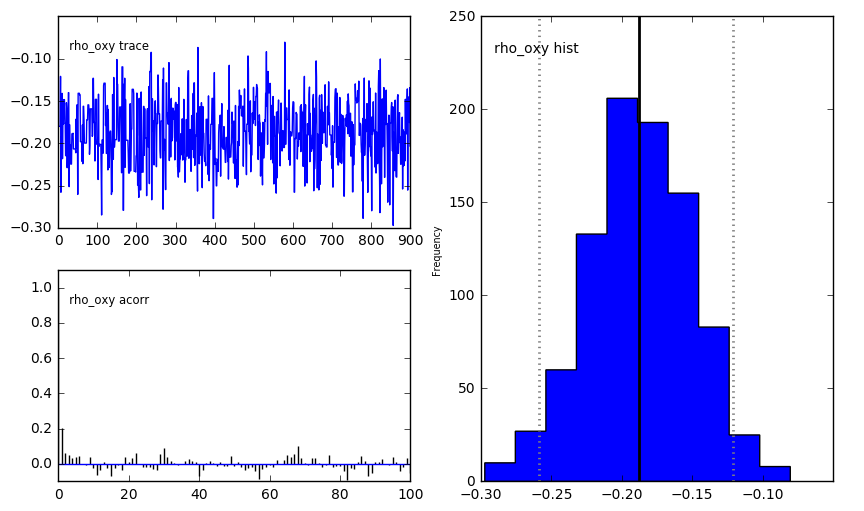

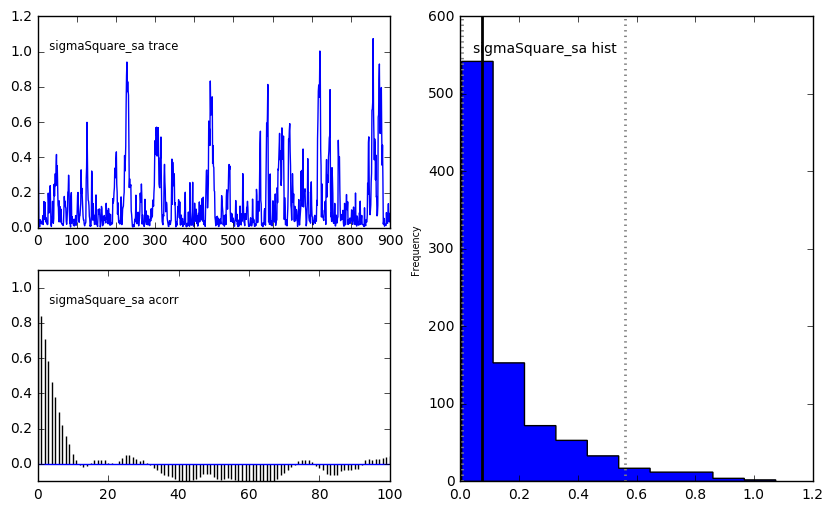

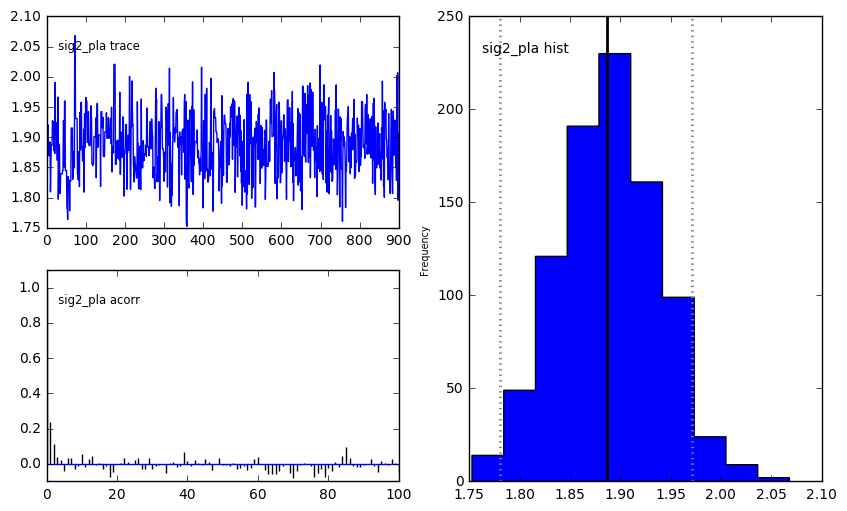

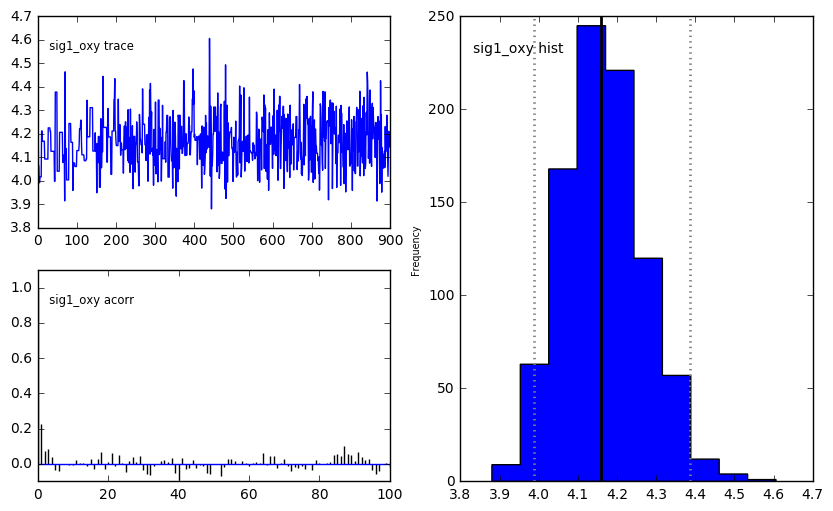

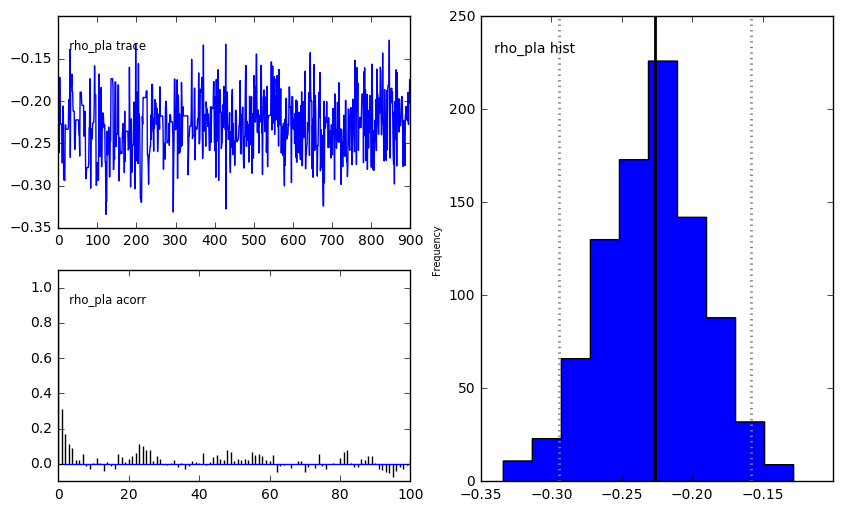

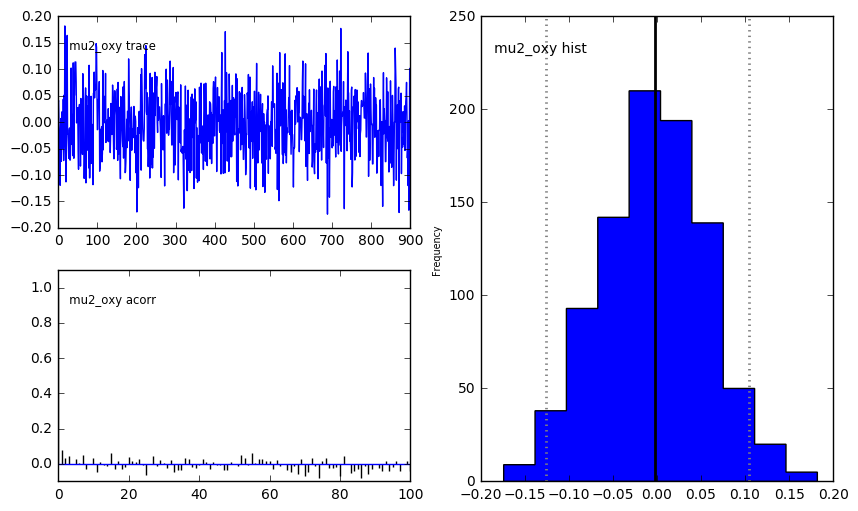

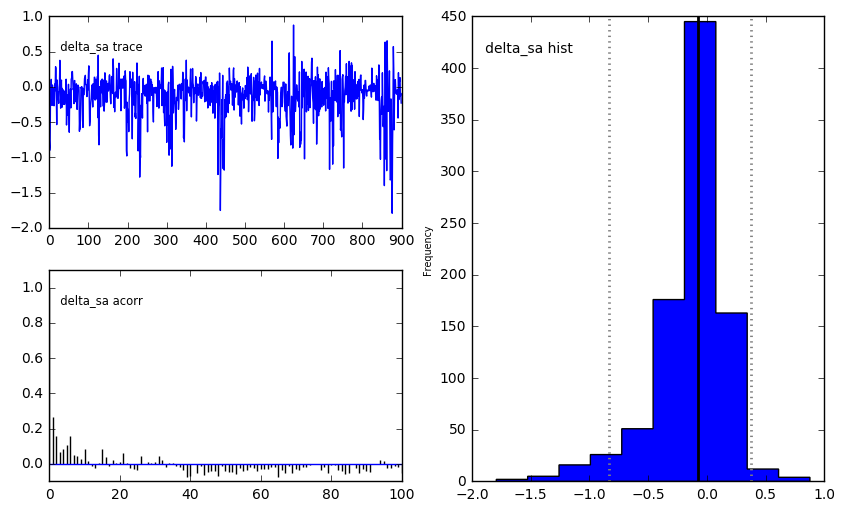

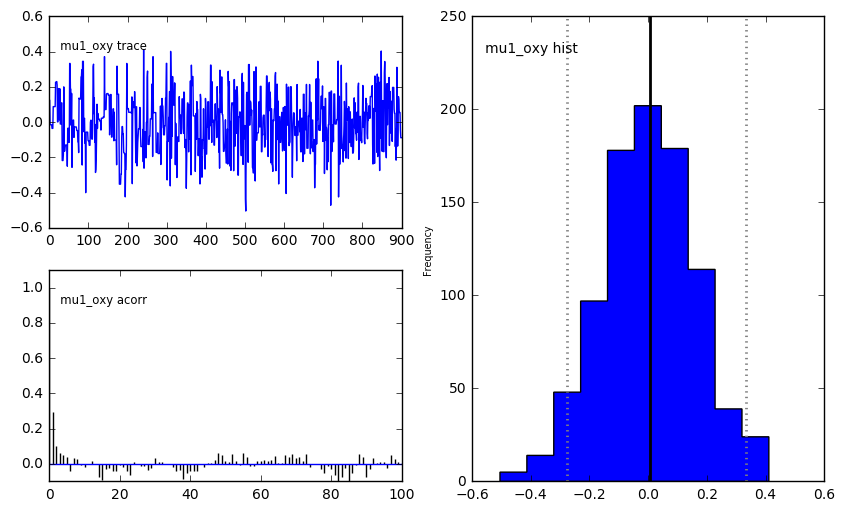

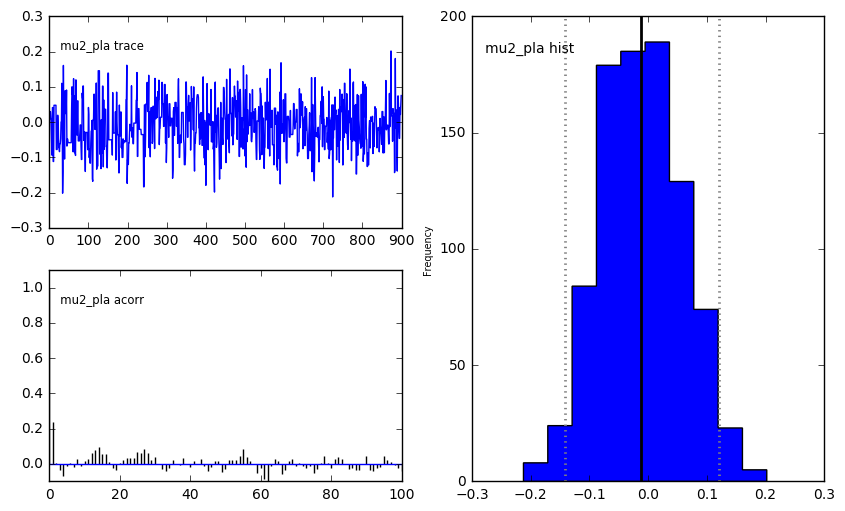

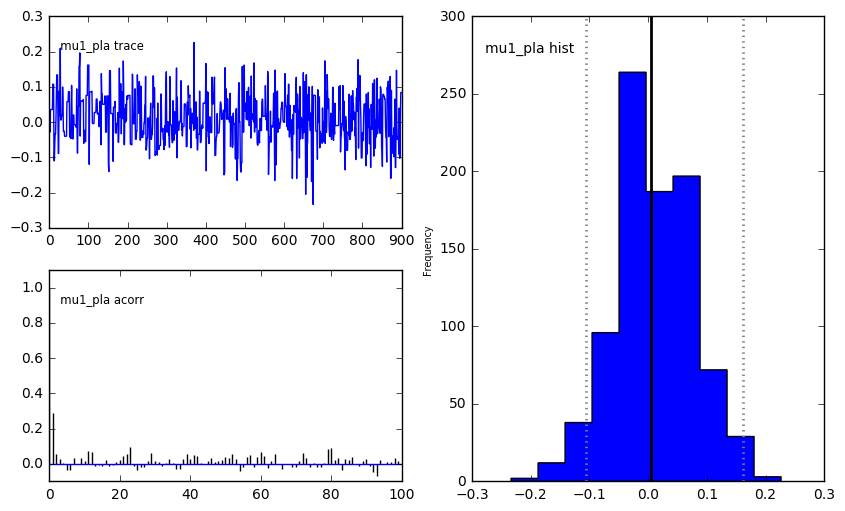

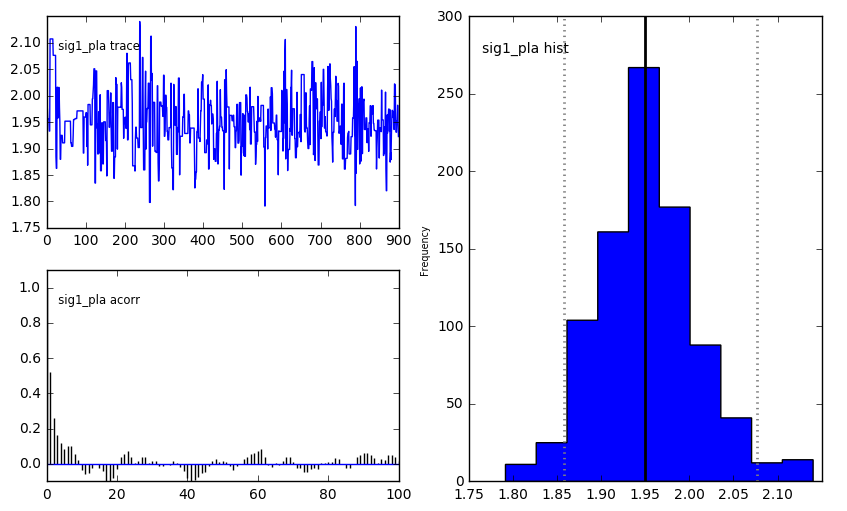

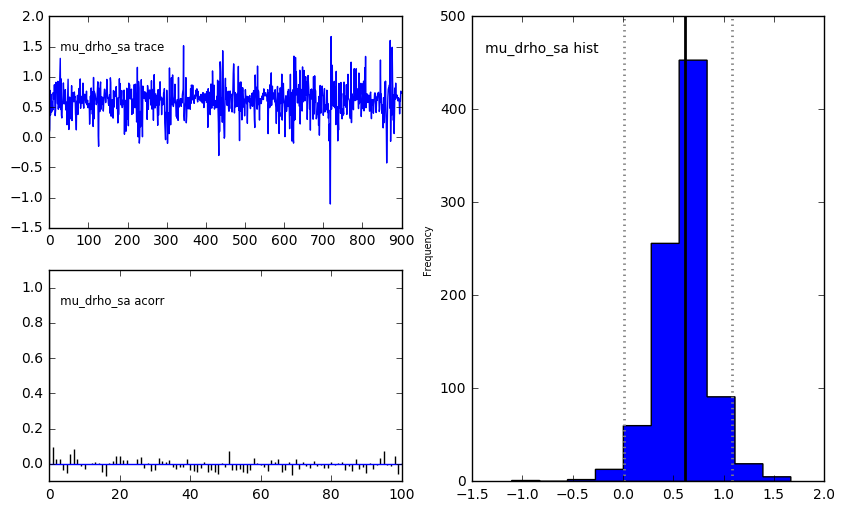

In [59]:
plot(m_sa)

In [61]:
corr_pla_sa=pearsonr(sup_pla,amy_pla)
print(corr_pla_sa)
corr_oxy_sa=pearsonr(sup_oxy,amy_oxy)
print(corr_oxy_sa)

(-0.22869722498865772, 2.8428914112961589e-10)
(-0.19021606238943484, 1.751440698125031e-07)
